In [1]:
import os
import sys
import time
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

# To ignore UserWarnings
import warnings
warnings.filterwarnings('ignore')

# Import local function
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))

from metrics import get_metrics_df
from narmax.utils import narmax_state_space

In [2]:
# Rawd data taken from https://github.com/DavidContrerasFranco/Feedback-Systems/blob/main/Covid-19-Model/covid_BaseModel.py
N = 49648685

Real_S = np.array([49648683, 49648682, 49648677, 49648671, 49648666, 49648663, 49648659, 49648650, 49648633, 49648620, \
                   49648606, 49648584, 49648539, 49648500, 49648450, 49648384, 49648283, 49648136, 49647994, 49647871, \
                   49647727, 49647573, 49647387, 49647230, 49647096, 49646956, 49646831, 49646683, 49646532, 49646373, \
                   49646231, 49646130, 49645996, 49645896, 49645737, 49645615, 49645493, 49645366, 49645239, 49645090, \
                   49644961, 49644840, 49644697, 49644540, 49644397, 49644185, 49644037])
Real_C = np.array([   2,    3,    8,   14,   19,   22,   26,   35,   51,   64, \
                     78,   98,  143,  176,  221,  282,  365,  495,  624,  722, \
                    854,  982, 1123, 1247, 1352, 1422, 1444, 1528, 1668, 1779, \
                   1852, 1861, 1903, 1897, 1904, 1928, 1940, 1923, 1969, 2023, \
                   2021, 1811, 1788, 1704, 1629, 1766, 1832])
Real_I_C = np.array([   0,    0,    0,    0,    0,    0,    0,    0,    1,    1, \
                        1,    3,    3,    9,   14,   18,   35,   51,   63,   87, \
                       99,  124,  168,  196,  221,  279,  368,  415,  408,  434, \
                      465,  523,  571,  638,  744,  798,  849,  929,  976, 1031, \
                     1120, 1385, 1484, 1663, 1813, 1799, 1790])
Real_I_H = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, \
                      0,  0,  0,  0,  0,  0,  0,  0,  0,  0, \
                      0,  0,  0,  0,  0,  0,  2,  2,  2,  3, \
                      5,  7, 10, 11, 18, 22, 29, 33, 37, 40, \
                     44, 55, 64, 71, 85, 87, 90])
Real_I_U = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, \
                      0,  0,  0,  0,  0,  0,  0,  0,  0,  0, \
                      0,  0,  0,  1,  1,  3,  3,  3,  3,  3, \
                      3,  5,  6, 10, 12, 15, 19, 23, 27, 30, \
                     36, 46, 53, 59, 70, 72, 75])
Real_R = np.array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, \
                     0,   0,   0,   0,   0,   1,   2,   3,   4,   5, \
                     5,   6,   7,  11,  15,  25,  37,  54,  72,  93, \
                   129, 159, 199, 233, 270, 307, 355, 411, 437, 471, \
                   503, 548, 599, 648, 691, 776, 861])

In [3]:
# Change raw data into population proportion
s = Real_S/N
c = Real_C/N
ic = Real_I_C/N
ih = Real_I_H/N
iu = Real_I_U/N
r = Real_R/N

x_train = x_test = np.stack((s, c, ic, ih, iu, r), axis=-1) # Test Overfit capability

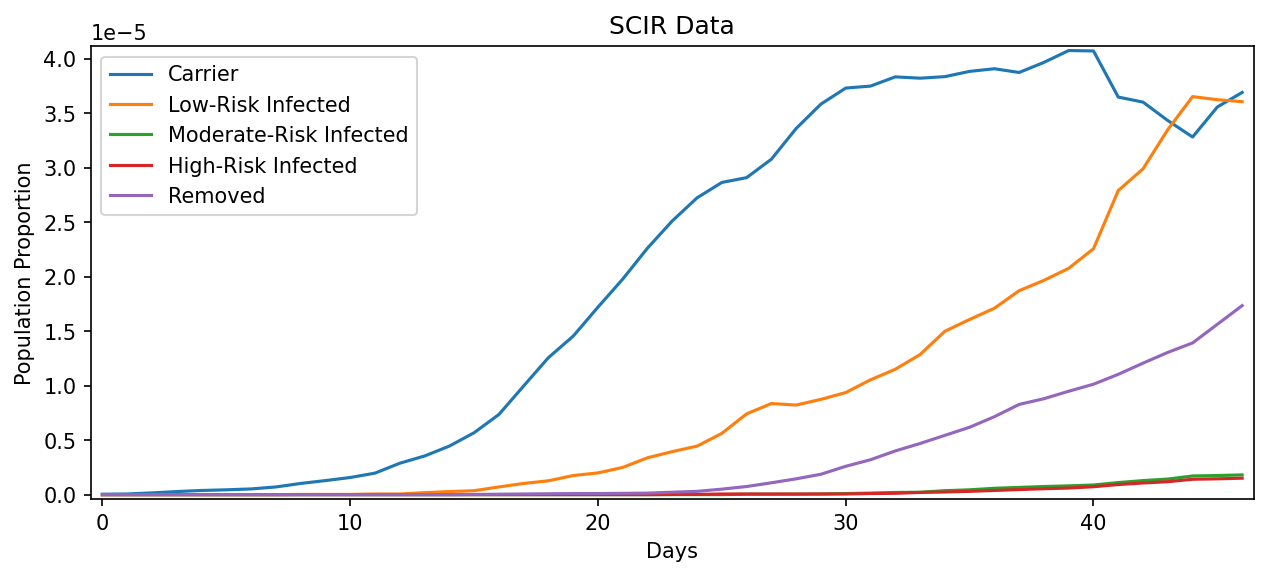

In [4]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SCIR Data')
plt.plot(c,label="Carrier")
plt.plot(ic,label="Low-Risk Infected")
plt.plot(ih,label="Moderate-Risk Infected")
plt.plot(iu,label="High-Risk Infected")
plt.plot(r,label="Removed")
plt.margins(0.01, tight=True)
plt.xlabel("Days")
plt.ylabel("Population Proportion")
plt.legend()
print(end='')

In [5]:
# Define SINDy Model
sindy_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    optimizer=ps.STLSQ(threshold=5e-8),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['s', 'c', 'ic', 'ih', 'iu', 'r']
)

# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t=np.arange(47))

s' = -7484604.838 1 + 10477746.969 s + 5992050.384 s^2 + -5992225.531 s^3 + -10479663.984 s^4 + 7486697.000 s^5
c' = 11139917.228 1 + -15594768.311 s + -8918432.779 s^2 + 8918594.443 s^3 + 15597596.782 s^4 + -11142907.363 s^5
ic' = -3072295.791 1 + 4300831.316 s + 2459628.972 s^2 + -2459573.449 s^3 + -4301586.342 s^4 + 3072995.294 s^5
ih' = 0.000
iu' = 0.000
r' = -926976.141 1 + 2781170.494 s + -2781412.566 s^2 + 927218.213 s^3


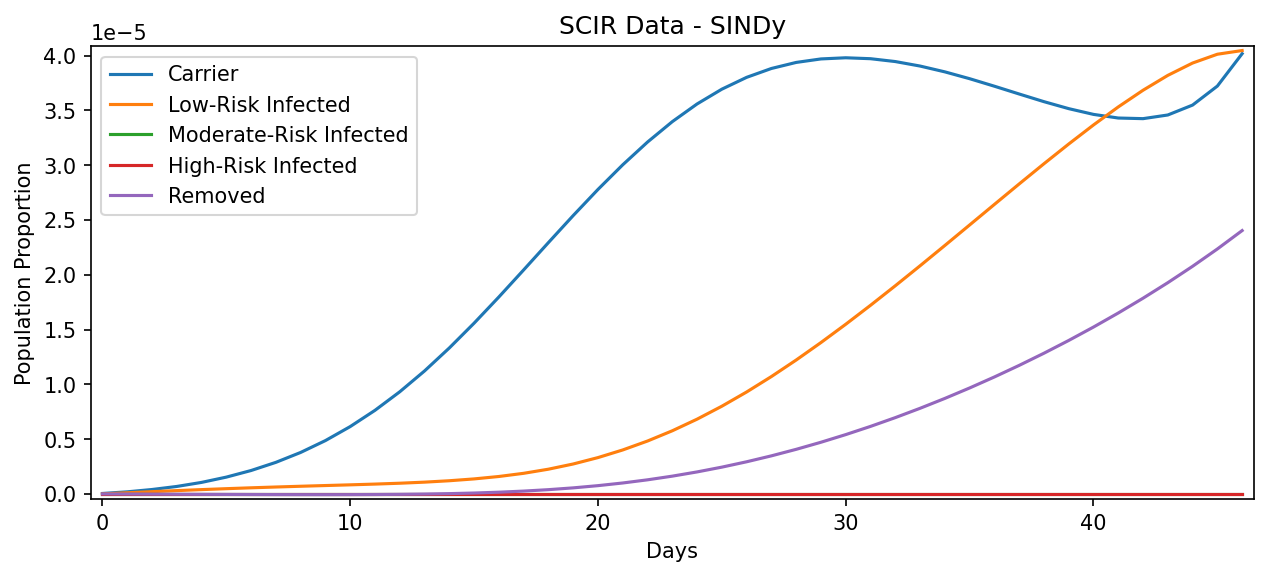

In [6]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SCIR Data - SINDy')
plt.plot(sindy_sim[:,1], label="Carrier")
plt.plot(sindy_sim[:,2], label="Low-Risk Infected")
plt.plot(sindy_sim[:,3], label="Moderate-Risk Infected")
plt.plot(sindy_sim[:,4], label="High-Risk Infected")
plt.plot(sindy_sim[:,5], label="Removed")
plt.margins(0.01, tight=True)
plt.xlabel("Days")
plt.ylabel("Population Proportion")
plt.legend()
print(end='')

In [7]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='aic',
    ylag=1, xlag=[[1],[1],[1],[1],[1]],
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)

narmax_model, narmax_sim, narmax_time = narmax_state_space(nx_model, x_train, x_test, ['s', 'c', 'ic', 'ih', 'iu', 'r'])

s[k+1] = -8.802E+03 s[k] + 3.452E+03 c[k]s[k]^4 - 3.452E+03 c[k] - 7.274E-01 r[k]s[k]^4 + 1.591E+00 ih[k]s[k]^4 + 1.761E+03 s[k]^5 + 7.042E+03 1 - 6.205E+00 iu[k] - 5.672E+03 ic[k] + 5.673E+03 ic[k]s[k]^4
c[k+1] = -1.992E+03 c[k] + 2.703E-02 s[k]^5 - 2.703E-02 1 + 9.443E-01 ic[k] + 5.791E-01 r[k]s[k]^4 + 6.697E+00 ih[k] - 2.046E+01 iu[k] + 1.993E+03 s[k]^4c[k]
ic[k+1] = 5.622E-01 c[k] + 7.246E-01 ic[k] + 8.575E-02 s[k]^5 - 8.575E-02 1 + 1.733E+00 r[k] + 2.168E+01 iu[k] - 1.475E+01 ih[k]
ih[k+1] = -6.449E-02 1 + 6.449E-02 s[k]^5 - 4.965E+02 c[k]s[k]^4 + 1.845E+02 ic[k] + 2.320E-01 r[k]s[k]^4 + 2.580E-01 ih[k] + 2.774E-01 iu[k] + 4.968E+02 c[k] - 2.359E+03 c[k]^2s[k]^3 - 1.843E+02 ic[k]s[k]^4
iu[k+1] = 9.080E-02 1 - 9.080E-02 s[k]^5 - 3.868E+02 c[k]s[k]^4 - 9.103E+01 ic[k]s[k]^4 - 5.477E-01 r[k]s[k]^4 + 4.354E-01 iu[k] - 5.932E-01 ih[k] + 3.864E+02 c[k] + 9.052E+01 ic[k] - 1.756E+03 c[k]^2s[k]^3
r[k+1] = 2.824E+02 1 + 1.883E+02 s[k]^5 + 3.265E+02 c[k]s[k]^4 + 2.653E+03 r[k] + 2.810E-01 i

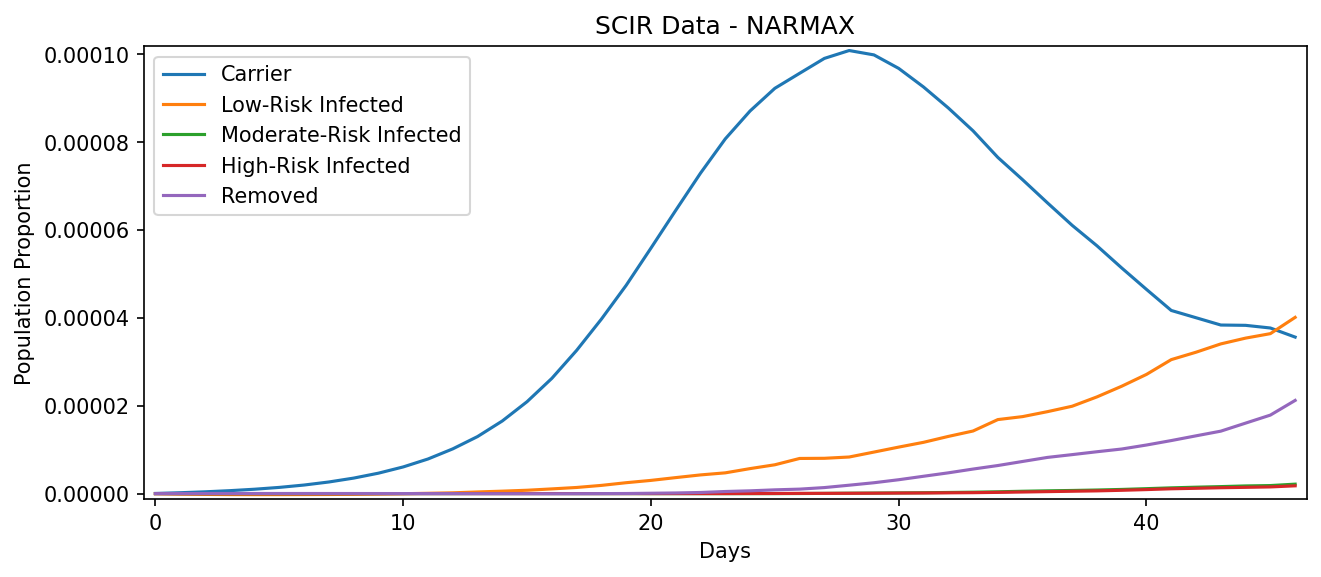

In [8]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SCIR Data - NARMAX')
plt.plot(narmax_sim[:,1], label="Carrier")
plt.plot(narmax_sim[:,2], label="Low-Risk Infected")
plt.plot(narmax_sim[:,3], label="Moderate-Risk Infected")
plt.plot(narmax_sim[:,4], label="High-Risk Infected")
plt.plot(narmax_sim[:,5], label="Removed")
plt.margins(0.01, tight=True)
plt.xlabel("Days")
plt.ylabel("Population Proportion")
plt.legend()
print(end='')

In [9]:
# Metrics DataFrame
get_metrics_df(x_test[:,1:], [1, 2, 2, 2, 2, 3], sindy_model, narmax_model, sindy_sim[:,1:], narmax_sim[:,1:], sindy_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,"[6.0, 6.0, 6.0, 0.0, 0.0, 4.0]","[5.0, 4.0, 4.0, 2.0, 2.0, 1.0]",22.0,-0.000002,1.371770e-11,0.372042,0.327674,0.020831
NARMAX,"[10.0, 8.0, 7.0, 10.0, 10.0, 10.0]","[9.0, 6.0, 5.0, 8.0, 8.0, 7.0]",55.0,-0.000005,2.263629e-10,0.766625,0.090756,3.741612
